In [1]:
%matplotlib inline

In [2]:
import numpy as np
import openturns as ot
import matplotlib.pyplot as plt

In [3]:
from matplotlib import rc
rc('font', **{'family': 'Libertine'})
rc('text', usetex=True)
rc('font', size=16)# Set the default text font size
rc('axes', titlesize=20)# Set the axes title font size
rc('axes', labelsize=16)# Set the axes labels font size
rc('xtick', labelsize=16)# Set the font size for x tick labels
rc('ytick', labelsize=16)# Set the font size for y tick labels
rc('legend', fontsize=16)# Set the legend font size

## Goodman - Gerber lines

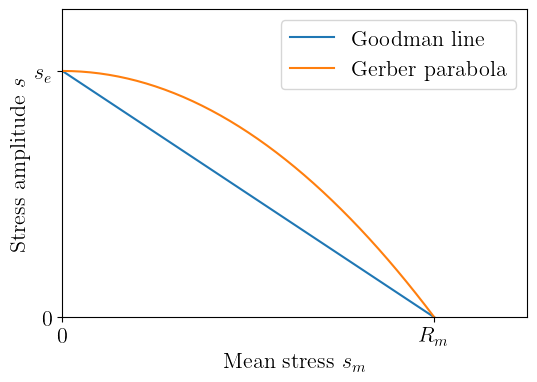

In [4]:
plt.figure(figsize=(6, 4))
xplot = np.arange(0, 151)
se = 20
Rm = 120
y_goodman = se - (se / Rm) * xplot
y_gerber = se - (se / Rm ** 2) * xplot ** 2

plt.plot(xplot, y_goodman, label='Goodman line')
plt.plot(xplot, y_gerber, label='Gerber parabola')
plt.ylim(0, 25)
plt.xlim(0, 150)
plt.xticks([0, 120], [0, '$R_m$'])
plt.yticks([0, 20], [0, '$s_e$'])

plt.xlabel('Mean stress $s_m$')
plt.ylabel('Stress amplitude $s$')
plt.legend()
plt.savefig("figures/haigh_diagram.png", bbox_inches='tight', dpi=300)

## Probabilistic SN curve

In [5]:
m1, m2 = 3, 5
loga1_design, loga2_design = 12.18, 16.13	
a1_design, a2_design = 10 ** loga1_design, 10 ** loga2_design

k = 0.25
t_ref = 0.025
matrix_lineq = np.array([[1, m1], [1, m2]])
vector_lineq = np.array([loga1_design, loga2_design])
log_N, log_s = list(np.linalg.solve(matrix_lineq, vector_lineq))
se = 10 ** log_s

external_radius = 4.6 / 2.0
internal_radius = np.sqrt((external_radius ** 2) - 1.28 / np.pi)
tube_thick = external_radius - internal_radius

se = se / ((tube_thick / t_ref) ** k)

def design_wohler(ss):
    external_radius = 4.6 / 2.0
    internal_radius = np.sqrt((external_radius ** 2) - 1.28 / np.pi)
    tube_thick = external_radius - internal_radius
    N = []
    for s in ss: 
        if s >= se:
            N.append(a1_design / ((s * (tube_thick / t_ref) ** k) ** m1))
        else:
            N.append(a2_design / ((s * (tube_thick / t_ref) ** k) ** m2))
    return N

sigma_logN_dnv = 0.2
loga1_med = loga1_design + 2. * sigma_logN_dnv
loga2_med = loga2_design + 2. * sigma_logN_dnv
a1_med, a2_med = 10 ** loga1_med, 10 ** loga2_med

def median_wohler(ss): 
    external_radius = 4.6 / 2.0
    internal_radius = np.sqrt((external_radius ** 2) - 1.28 / np.pi)
    tube_thick = external_radius - internal_radius
    N = []
    for s in ss: 
        if s >= se:
            N.append(a1_med / ((s * (tube_thick / t_ref) ** k) ** m1))
        else:
            N.append(a2_med / ((s * (tube_thick / t_ref) ** k) ** m2))
    return N

In [6]:
def random_wohler(ss, eps): 
    external_radius = 4.6 / 2.0
    internal_radius = np.sqrt((external_radius ** 2) - 1.28 / np.pi)
    tube_thick = external_radius - internal_radius
    N = []
    for s in ss: 
        if s >= se:
            N.append((eps * a1_med) / ((s * (tube_thick / t_ref) ** k) ** m1))
        else:
            N.append((eps * a2_med) / ((s * (tube_thick / t_ref) ** k) ** m2))
    return N

In [7]:
sn_dist = ot.LogNormal()
sn_dist.setParameter(ot.LogNormalMuSigma()([1., 0.3, 0.0]))
sn_coeff_sample = np.array(sn_dist.getSample(200))

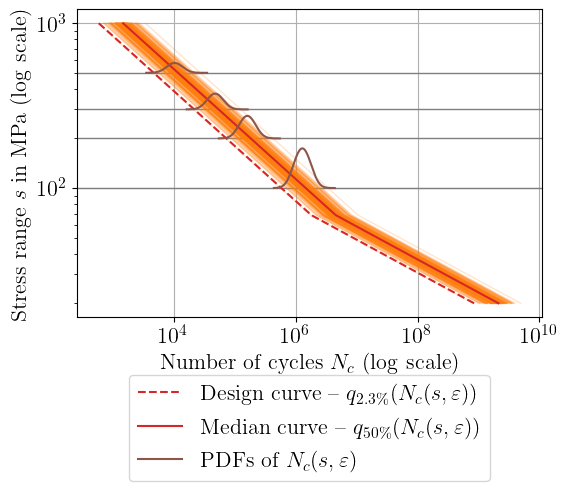

In [9]:
plt.figure(figsize=(6, 4))
yplot = np.arange(20, 1000, 1)
x_pdf_plot = np.linspace(0.3, 3, 100000).reshape(-1, 1)
pdf = np.array(sn_dist.computePDF(x_pdf_plot))
plt.axhline(100., color='C7', linewidth=1.)
plt.axhline(200., color='C7', linewidth=1.)
plt.axhline(300., color='C7', linewidth=1.)
plt.axhline(500., color='C7', linewidth=1.)
for sn_coeff in sn_coeff_sample:
    plt.plot(random_wohler(yplot, sn_coeff), yplot, color='C1', alpha=0.2, linewidth=1.)
plt.plot(design_wohler(yplot), yplot, color='C3', label="Design curve -- $q_{2.3\%}(N_c(s, \\varepsilon))$", linestyle='dashed')
plt.plot(median_wohler(yplot), yplot, color='C3', label="Median curve -- $q_{50\%}(N_c(s, \\varepsilon))$")

plt.plot(median_wohler([100.])[0] * x_pdf_plot, 100. + pdf * 50, color='C5')
plt.plot(median_wohler([200.])[0] * x_pdf_plot, 200. + pdf * 50, color='C5')
plt.plot(median_wohler([300.])[0] * x_pdf_plot, 300. + pdf * 50, color='C5')
plt.plot(median_wohler([500.])[0] * x_pdf_plot, 500. + pdf * 50, color='C5', label='PDFs of $N_c(s, \\varepsilon)$')

plt.yscale('log')
plt.xscale('log')
plt.xlabel('Number of cycles $N_c$ (log scale)')
plt.ylabel('Stress range $s$ in MPa (log scale)')
plt.grid()
plt.legend(bbox_to_anchor=(0.5, -0.15), loc='upper center')
plt.savefig('figures/probabilistic_fatigue.png', dpi=300, bbox_inches='tight');